### CSTR with Noise and Jumps

$$\frac{dC_A}{dt} = \frac{F}{V_R}\left(C_{in} - C_A\right) - r, \\[6pt]
\frac{dT}{dt} = \frac{F}{V_R}(T_f - T) - \frac{\Delta H}{\rho C_P}\, r - \frac{UA}{\rho C_P V_R}(T-T_c), \\[6pt]
r = k_0\, \exp\!\left(-\frac{E/R}{T}\right)\,C_A.$$

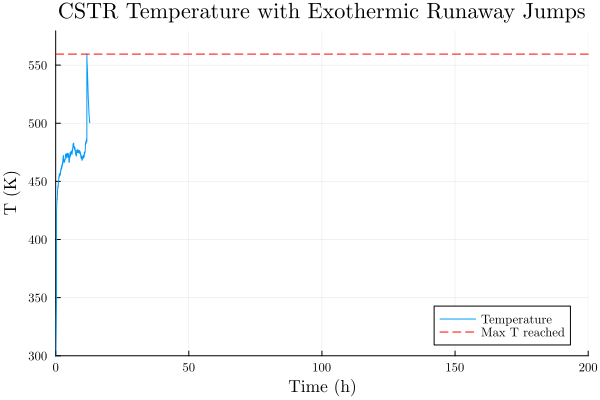

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606


"/Users/rafif/Documents/Purdue Courses/gradcourses/figs/cstr_temperature_runaway.pdf"

In [13]:
using DifferentialEquations
using Random
using Plots
default(fontfamily="Computer Modern")

# =========================
# CSTR + Heat Balance Params
# =========================

mutable struct CSTRParams
    F::Float64                # volumetric flow rate
    V::Float64                # reactor volume
    C_in::Float64             # inlet concentration
    T_in::Float64             # inlet temperature
    T_c::Float64              # coolant temperature

    k0::Float64               # pre-exponential factor
    E_over_R::Float64         # E/R (activation energy / gas constant)
    beta::Float64             # H/(ρCp)
    k_cool::Float64           # UA/(ρCpV)

    sigma_C::Float64          # noise intensity for concentration
    sigma_T::Float64          # noise intensity for temperature

    ΔT_jump::Float64          # temperature jump size at failure
    τ_mean_fail::Float64      # mean quiescence time between failures
    next_jump::Float64        # absolute time of next failure
end

# Helper: sample exponential waiting time with mean τ_mean
exp_wait(τ_mean) = -τ_mean * log(rand())

# -------------------------
# Choose some example values
# -------------------------
F         = 1.0        # m3/h
V         = 1.0        # m3
C_in      = 10.0       # mol/m3
T_in      = 475.0      # K
T_c       = 290.0      # K (coolant a bit colder)

k0        = 35e6                # 1/h
E_over_R  = 49.55e3/8.314       # K
beta      = -6e-6               # (m3 K) / kmol
k_cool    = 0.3                 # 1 / K

sigma_C   = 0.01       # concentration noise intensity
sigma_T   = 0.01       # temperature noise intensity

ΔT_jump   = 75.0       # runaway
τ_mean_fail = 30.0     # mean time between failures (quiescence time)

# First failure scheduled from t = 0
p = CSTRParams(
    F, V, C_in, T_in, T_c,
    k0, E_over_R, beta, k_cool,
    sigma_C, sigma_T,
    ΔT_jump, τ_mean_fail,
    exp_wait(τ_mean_fail)  # next_jump
)

# =========================
# Drift (deterministic part)
# =========================
function drift!(du, u, p::CSTRParams, t)
    C = u[1]
    T = u[2]

    # Arrhenius rate
    r = p.k0 * exp(-p.E_over_R / T) * C

    # Material balance
    du[1] = (p.F / p.V) * (p.C_in - C) - r

    # Energy balance (lumped form)
    du[2] = (p.F / p.V) * (p.T_in - T)
            - p.beta * r 
            - p.k_cool * (T - p.T_c)
end

# =========================
# Diffusion (stochastic part)
# =========================
function diffusion!(du, u, p::CSTRParams, t)
    du[1] = p.sigma_C * u[1]
    du[2] = p.sigma_T * u[2] #sign(u[2]-290) * abs(u[2]-290)^1.5
end

# =========================
# Jump / failure mechanism
# =========================

# Condition: trigger when t == p.next_jump
function jump_condition(u, t, integrator)
    t - integrator.p.next_jump
end

# Effect: runaway heat spike in T, then schedule next failure
function jump_affect!(integrator)
    # Apply exothermic runaway
    integrator.u[2] += integrator.p.ΔT_jump

    # Schedule the next failure
    τ = exp_wait(integrator.p.τ_mean_fail)
    integrator.p.next_jump = integrator.t + τ
end

jump_cb = ContinuousCallback(
    jump_condition,
    jump_affect!;
    save_positions = (true, true) # save before & after jump
)

# =========================
# Problem setup & solution
# =========================

# Initial states
C0   = 1.0
T0   = 300.0
u0   = [C0, T0]

Tfinal = 200.0
tspan  = (0.0, Tfinal)
dt     = 0.01

jump_prob = SDEProblem(drift!, diffusion!, u0, tspan, p)

jump_sol = solve(
    jump_prob,
    EM(),
    dt = dt,
    callback = jump_cb
)

max_T = maximum([u[2] for u in jump_sol.u])

# =========================
# Plot: Temperature + Concentration
# =========================

plt1 = plot(jump_sol.t, [u[2] for u in jump_sol.u],
            xlabel = "Time (h)",
            ylabel = "T (K)",
            label = "Temperature",
            title = "CSTR Temperature with Exothermic Runaway Jumps",
            xlims = (0, Tfinal),
            ylims = (300, max_T + 20),
            legend = true,
            grid = true)

# Plot a horizontal line for max temperature reached by the Jumps and the text label
hline!([max_T], linestyle = :dash, color = :red, label = "Max T reached")
display(plt1)
savefig("figs/cstr_temperature_runaway.pdf")

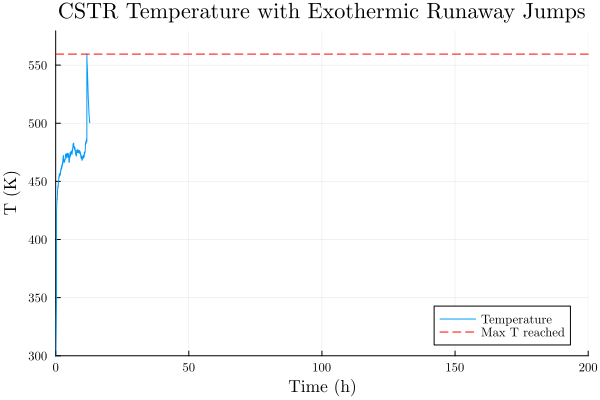

"/Users/rafif/Documents/Purdue Courses/gradcourses/figs/cstr_temperature_runaway2.pdf"

In [14]:
plt1 = plot(jump_sol.t, [u[2] for u in jump_sol.u],
            xlabel = "Time (h)",
            ylabel = "T (K)",
            label = "Temperature",
            title = "CSTR Temperature with Exothermic Runaway Jumps",
            xlims = (0, Tfinal),
            ylims = (300, max_T + 20),
            legend = true,
            grid = true)

# Plot a horizontal line for max temperature reached by the Jumps and the text label
hline!([max_T], linestyle = :dash, color = :red, label = "Max T reached")
display(plt1)
savefig("figs/cstr_temperature_runaway2.pdf")

In [15]:
max_T

559.466394363683

In [16]:
using Statistics
# Ensemble jump problems to find the average max temperature reached
num_ensembles = 500
max_temps = Float64[]
for i in 1:num_ensembles
    # Reset next jump time for each ensemble member
    p.next_jump = exp_wait(p.τ_mean_fail)

    jump_prob = SDEProblem(drift!, diffusion!, u0, tspan, p)

    jump_sol = solve(
        jump_prob,
        EM(),
        dt = dt,
        callback = jump_cb
    )

    max_T = maximum([u[2] for u in jump_sol.u])
    push!(max_temps, max_T)
end
average_max_T = mean(max_temps)
println("Average Max Temperature reached over ", num_ensembles, " ensembles: ", average_max_T, " K")

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/

Average Max Temperature reached over 500 ensembles: 556.8021845177396 K


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/.julia/packages/SciMLBase/8XHkk/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/rafif/

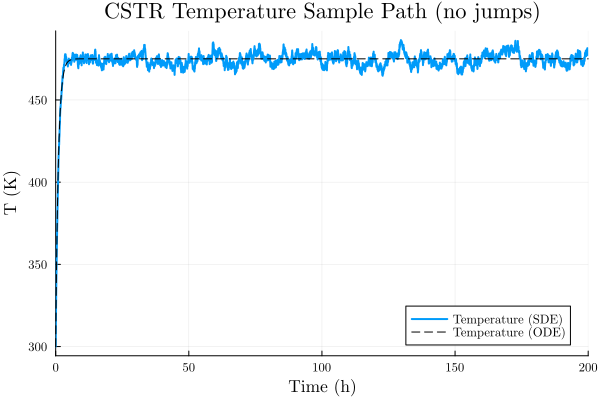

"/Users/rafif/Documents/Purdue Courses/gradcourses/figs/cstr_temperature_no_jump.pdf"

In [17]:
# SDE problem without Jumps
sdeprob = SDEProblem(drift!, diffusion!, u0, tspan, p)
sdesol = solve(
    sdeprob,
    EM(),
    dt = dt,
)

# ODE Problem
odeprob = ODEProblem(drift!, u0, tspan, p)
odesol = solve(odeprob, Tsit5())

# Plot
plt2 = plot(sdesol.t, [u[2] for u in sdesol.u],
            xlabel = "Time (h)",
            ylabel = "T (K)",
            label = "Temperature (SDE)",
            title = "CSTR Temperature Sample Path (no jumps)",
            xlims = (0, Tfinal),
            legend = true,
            grid = true,
            lw = 2)

plot!(plt2, odesol.t, [u[2] for u in odesol.u],
      label = "Temperature (ODE)",
      linestyle = :dash, color = :black)
      
display(plt2)
savefig("figs/cstr_temperature_no_jump.pdf")

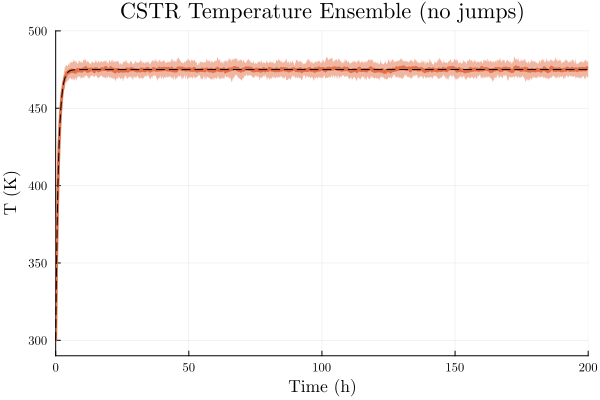

"/Users/rafif/Documents/Purdue Courses/gradcourses/figs/cstr_temperature_ensemble_no_jump.pdf"

In [12]:
# Ensemble simulations without Jumps
num_ensembles = 50
ensembleprob = EnsembleProblem(sdeprob, prob_func = (prob,i,repeat) -> remake(prob))
ensemble_sol = solve(
    ensembleprob,
    EM(),
    EnsembleThreads(),
    trajectories=num_ensembles,
    dt=dt,
    saveat=0.1,
)
summ = EnsembleSummary(ensemble_sol)

plt3 = plot(summ, fillalpha=0.5, xlims = (0,Tfinal), ylims=(290,500),
            xlabel = "Time (h)",
            ylabel = "T (K)",
            title = "CSTR Temperature Ensemble (no jumps)",
            label = "Ensemble Trajectories",
            legend = false,
            grid = true)

plot!(plt3, odesol.t, [u[2] for u in odesol.u],
      label = "Temperature (ODE)",
      linestyle = :dash, color = :black)

display(plt3)
savefig("figs/cstr_temperature_ensemble_no_jump.pdf")